In [1]:
%pip install -r requirements.txt 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 82.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 102.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.2/31.2 MB 43.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 2.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 95.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 51.7 MB/s eta 0:00:00:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 97.0 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 25.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.3/214.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 944.1/944.1 kB 20.1 MB/s eta 0:00:0000:

In [1]:
# Imports 

import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, \
precision_recall_curve, auc
from stepbystep.v0 import StepByStep

### Data generation

In [67]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

In [2]:
X,y = make_moons(n_samples=100,noise=0.3,random_state=0)

In [3]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,random_state=13)

In [4]:
sc = StandardScaler()
sc.fit(X_train)

X_train = sc.transform(X_train)
X_val = sc.transform(X_val)

### Data preparation

In [5]:
torch.manual_seed(13)

x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1,1)).float()

x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1,1)).float()

train_dataset = TensorDataset(x_train_tensor,y_train_tensor)
val_dataset = TensorDataset(x_val_tensor,y_val_tensor)

train_loader = DataLoader(train_dataset,batch_size=16,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size = 16)

### Logistic regression

In [15]:
torch.manual_seed(42)

model1 = nn.Sequential() 
model1.add_module('linear',nn.Linear(2,1))
model1.add_module('sigmoid',nn.Sigmoid())
model1.state_dict()

OrderedDict([('linear.weight', tensor([[0.5406, 0.5869]])),
             ('linear.bias', tensor([-0.1657]))])

In [16]:
#BCE the intuitive way

dummy_labels = torch.tensor([1.0, 0.0])
dummy_predictions = torch.tensor([.9, .2])
# Positive class (labels == 1)
positive_pred = dummy_predictions[dummy_labels == 1] 
first_summation = torch.log(positive_pred).sum()
# Negative class (labels == 0)
negative_pred = dummy_predictions[dummy_labels == 0] 
second_summation = torch.log(1 - negative_pred).sum() 

# n_total = n_pos + n_neg
n_total = dummy_labels.size(0)
loss = -(first_summation + second_summation) / n_total
loss

tensor(0.1643)

In [17]:
# BCE loss the usual way

summation = torch.sum(
    dummy_labels * torch.log(dummy_predictions) +
    (1 - dummy_labels) * torch.log(1 - dummy_predictions)
)
loss = -summation / n_total
loss

tensor(0.1643)

In [18]:
loss_fn = nn.BCELoss(reduction='mean')
loss_fn

BCELoss()

In [19]:
loss_fn_logits = nn.BCEWithLogitsLoss(reduction='mean')
loss_fn_logits

BCEWithLogitsLoss()

In [23]:
def log_odds_ratio(p):
    return np.log(p/(1-p))

logit1 = log_odds_ratio(.9)
logit2 = log_odds_ratio(.2)
dummy_labels = torch.tensor([1.0, 0.0])
dummy_logits = torch.tensor([logit1, logit2])
print(dummy_logits)

loss_fn_logits(dummy_logits, dummy_labels)

tensor([ 2.1972, -1.3863], dtype=torch.float64)


tensor(0.1643)

Imbalanced dataset in logistic

In [37]:
dummy_imb_labels = torch.tensor([1.0, 0.0, 0.0, 0.0])
dummy_imb_logits = torch.tensor([logit1, logit2, logit2, logit2])

In [42]:
n_neg = (dummy_imb_labels == 0).sum().float()
n_pos = (dummy_imb_labels == 1).sum().float()

pos_weight = (n_neg/n_pos).view(1,)
pos_weight

tensor([3.])

In [43]:
loss_fn_imb = nn.BCEWithLogitsLoss(
        reduction='mean',
        pos_weight=pos_weight
)

In [44]:
loss_fn_imb(dummy_imb_logits, dummy_imb_labels)

tensor(0.2464)

### Training the model

In [13]:
# model config

lr = 0.1

torch.manual_seed(42)

model = nn.Sequential()
model.add_module('linear',nn.Linear(2,1))

optimizer = optim.SGD(model.parameters(),lr = lr)

loss_fn = nn.BCEWithLogitsLoss(reduction='mean')

True True


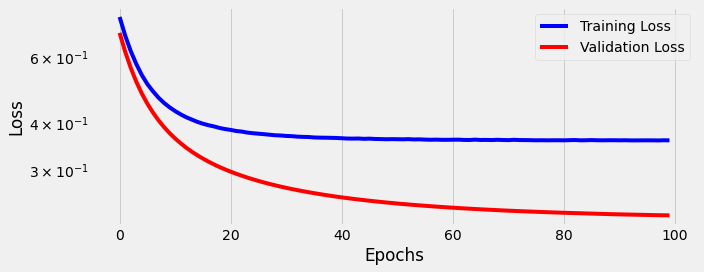

In [14]:
# Training

n_epochs = 100

sbs = StepByStep(model = model,loss_fn=loss_fn,optimizer=optimizer,mps=True)
sbs.set_loaders(train_loader,val_loader)
sbs.train(n_epochs)
fig = sbs.plot_losses()

In [16]:
model.state_dict()

OrderedDict([('linear.weight', tensor([[ 1.1806, -1.8693]], device='mps:0')),
             ('linear.bias', tensor([-0.0591], device='mps:0'))])

In [17]:
predictions = sbs.predict(x_train_tensor[:4])
predictions

array([[ 0.20345579],
       [ 2.944445  ],
       [ 3.6933172 ],
       [-1.2334074 ]], dtype=float32)

In [19]:
torch.sigmoid(torch.as_tensor(predictions))

tensor([[0.5507],
        [0.9500],
        [0.9757],
        [0.2256]])

In [24]:
(predictions >= 0).astype(int)

array([[1],
       [1],
       [1],
       [0]])